In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
import joblib
from xgboost import XGBClassifier
from tabulate import tabulate
import os
from matplotlib.colors import LinearSegmentedColormap

## NSL KDD dataset
## Source: https://www.kaggle.com/datasets/hassan06/nslkdd¶

In [7]:
features=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "level"]

In [9]:
kdddset = pd.read_csv('/Users/ramejha/Documents/BitsProject/datasets/nslkdd/nsl-kdd/KDDTrain+.txt', names=features)

In [11]:
kdddset.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [13]:
kdddset.shape

(125973, 43)

In [15]:
set(kdddset['attack'].values)

{'back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster'}

In [17]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [19]:
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
    'teardrop': 'DoS', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R'
}

In [21]:
kdddset['attack_group'] = kdddset['attack'].map(attack_mapping).fillna('normal')

In [23]:
set(kdddset['attack_group'].values)

{'DoS', 'Probe', 'R2L', 'U2R', 'normal'}

In [132]:
# 1. Distribution of Numerical Features
kdddset.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
protocol_type,125973.0,1.053202,4.266196e-01,0.0,1.00,1.00,1.00,2.000000e+00
service,125973.0,31.226469,1.634647e+01,0.0,20.00,24.00,49.00,6.900000e+01
flag,125973.0,6.979996,2.689365e+00,0.0,5.00,9.00,9.00,1.000000e+01
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01


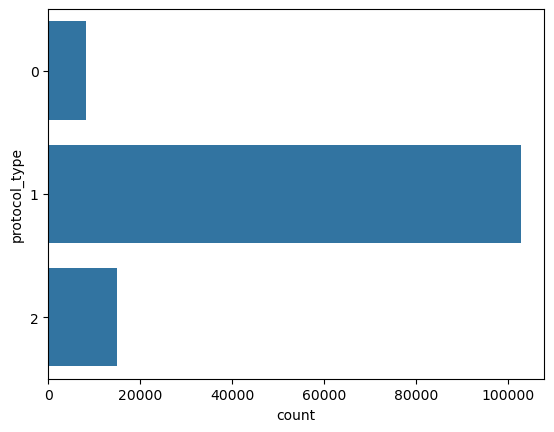

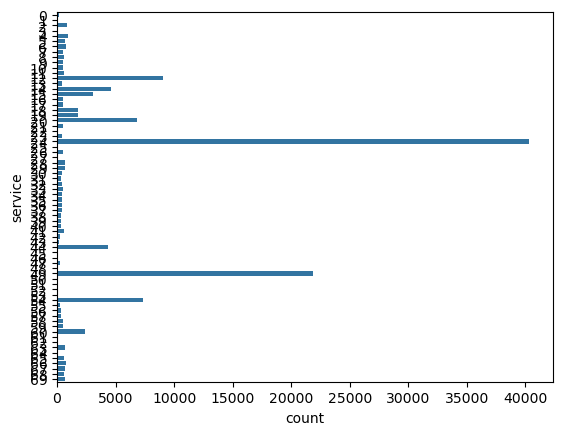

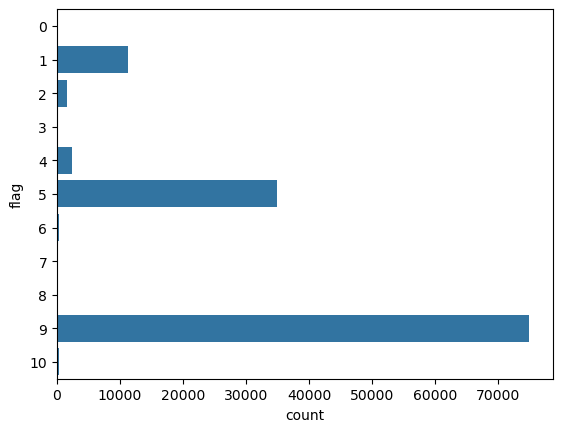

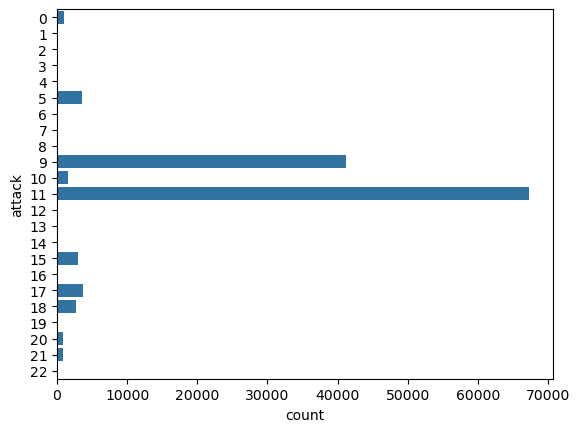

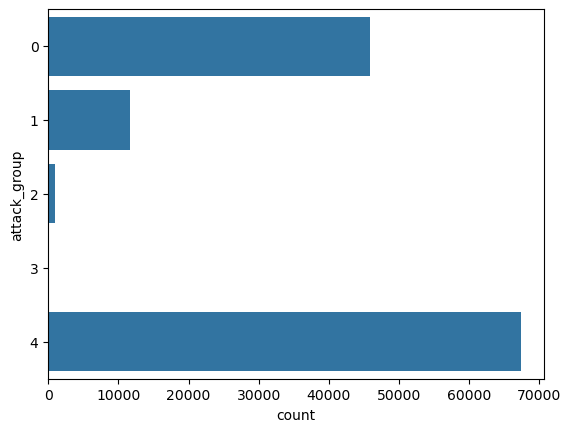

In [134]:
# 2. Distribution of Categorical Features
for col in ['protocol_type', 'service', 'flag', 'attack', 'attack_group']:
    sns.countplot(y=col, data=kdddset)
    plt.show()

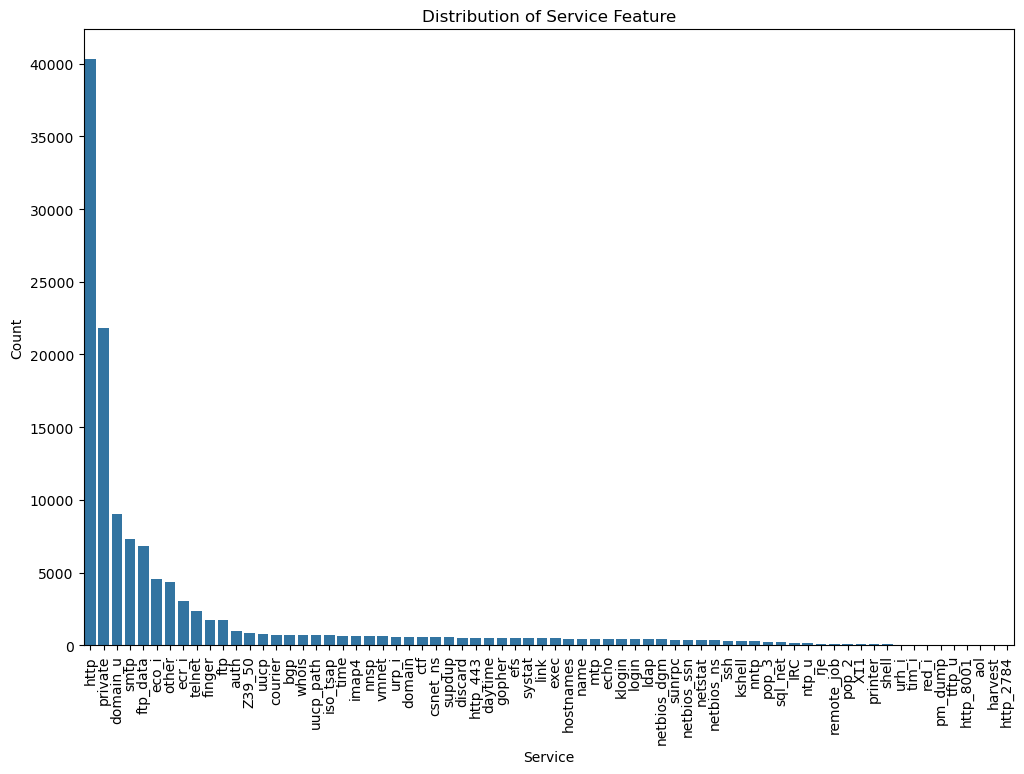

In [29]:
# Plot with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.countplot(x='service', data=kdddset, order=kdddset['service'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of Service Feature')
plt.show()

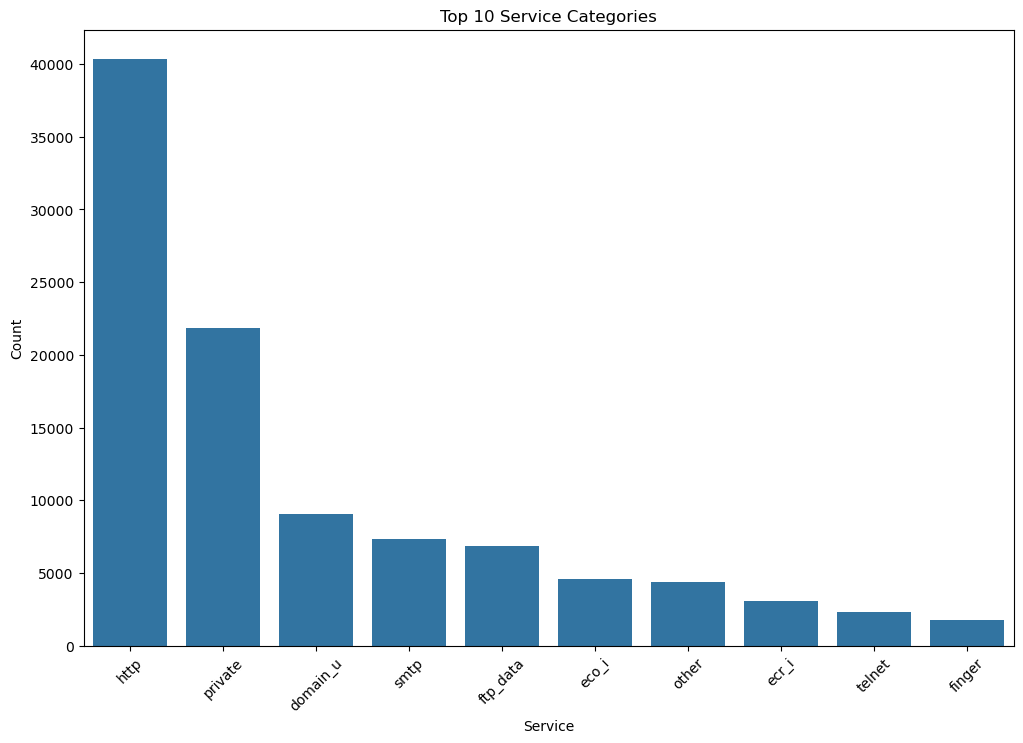

In [31]:
# Plotting only the top N most frequent services
top_n = 10
top_services = kdddset['service'].value_counts().nlargest(top_n).index
plt.figure(figsize=(12, 8))
sns.countplot(x='service', data=kdddset[kdddset['service'].isin(top_services)], order=top_services)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Service')
plt.ylabel('Count')
plt.title(f'Top {top_n} Service Categories')
plt.show()

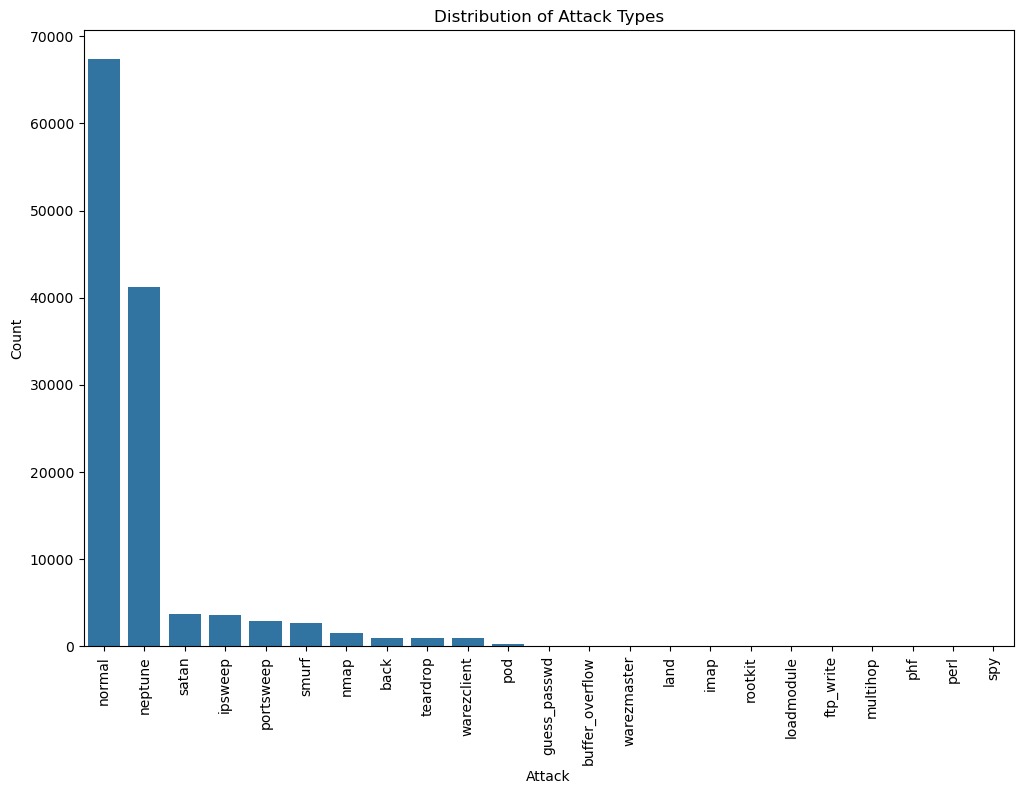

In [33]:
# Plot with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.countplot(x='attack', data=kdddset, order=kdddset['attack'].value_counts().index)
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.title('Distribution of Attack Types')
plt.show()

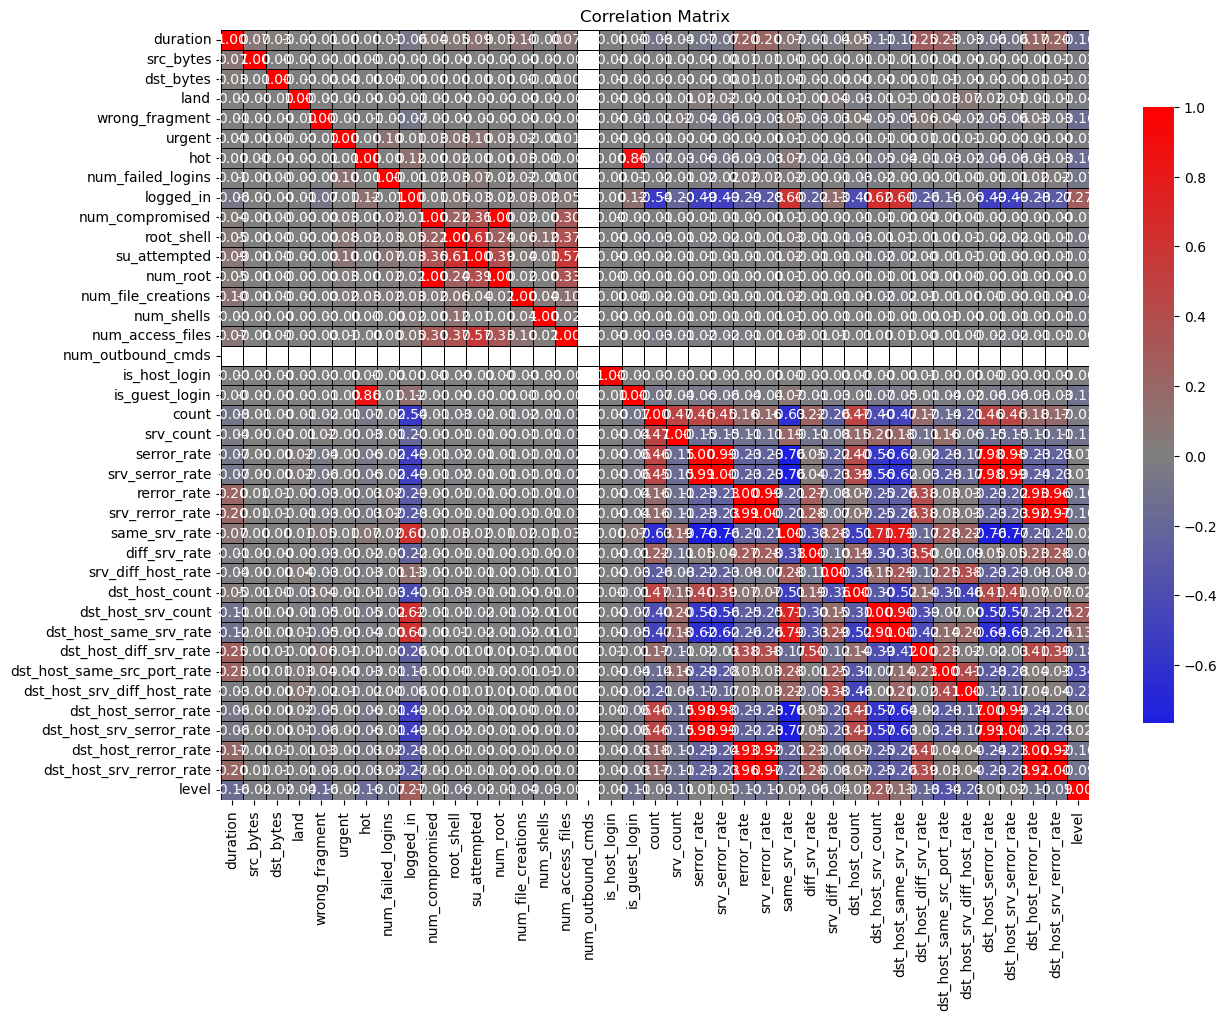

In [35]:
# 3. Correlation Matrix
# Define the custom colormap
colors = ["blue", "grey", "red"]
cmap_name = "red_blue_grey"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


numeric_data = kdddset.drop(columns=['protocol_type', 'service', 'flag', 'attack', 'attack_group'])
correlation = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))  # Increase the size of the plot for readability
sns.heatmap(correlation, annot=True, fmt=".2f", cmap=custom_cmap, center=0, 
            linewidths=.5, linecolor='black', cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')
plt.show()

Importance of each of the 42 fields in the NSL-KDD dataset for detecting intrusions. Each feature's importance will depend on its ability to distinguish between normal and anomalous behavior in the network traffic.

1.	duration: Length of the connection in seconds. Longer durations can sometimes indicate normal activity, but very short or excessively long durations might be suspicious.
2.	protocol_type: Type of protocol (TCP, UDP, ICMP). Certain types of attacks are protocol-specific, so this is important.
3.	service: Network service on the destination (e.g., HTTP, FTP). Some services are more vulnerable to specific attacks, making this a crucial feature.
4.	flag: Status flag of the connection. Indicates the state of the connection, e.g., whether it was successful or reset. Certain flags are indicative of attacks.
5.	src_bytes: Number of data bytes sent from the source to the destination. Unusually high or low values may indicate anomalies.
6.	dst_bytes: Number of data bytes sent from the destination to the source. Similar to src_bytes, anomalies may indicate malicious activity.
7.	land: Binary feature indicating if the connection is to/from the same host/port. It's often used to identify land attacks.
8.	wrong_fragment: Number of wrong fragments. Non-zero values might indicate attacks attempting to bypass detection.
9.	urgent: Number of urgent packets. A higher number of urgent packets can be a sign of malicious activity.
10.	hot: Number of "hot" indicators in the content, like failed logins. A high count can indicate suspicious behavior.
11.	num_failed_logins: Number of failed login attempts. Multiple failed attempts can suggest a brute force attack.
12.	logged_in: Binary feature indicating if the login was successful. Important for distinguishing between successful and failed login attempts.
13.	num_compromised: Number of compromised conditions. A higher number suggests an ongoing attack.
14.	root_shell: Binary feature indicating if a root shell was obtained. Critical for detecting privilege escalation attacks.
15.	su_attempted: Binary feature indicating if an su command was attempted. Important for identifying privilege escalation attempts.
16.	num_root: Number of root accesses. Frequent root access attempts are suspicious.
17.	num_file_creations: Number of file creation operations. Excessive file creations may indicate malware activity.
18.	num_shells: Number of shell prompts invoked. Multiple shells can indicate intrusion.
19.	num_access_files: Number of times files were accessed. High access rates might be indicative of reconnaissance or exploitation.
20.	num_outbound_cmds: Number of outbound commands in an FTP session. Relevant for identifying data exfiltration via FTP.
21.	is_host_login: Binary feature indicating if the login was to the host. Typically less important unless analyzing host-specific attacks.
22.	is_guest_login: Binary feature indicating if the login was as a guest. Guest logins can be indicative of lower privilege access, possibly used for reconnaissance.
23.	count: Number of connections to the same host as the current connection in the past 2 seconds. High counts may indicate scanning or DoS attacks.
24.	srv_count: Number of connections to the same service as the current connection in the past 2 seconds. Similar to count, used to detect service-specific attacks.
25.	serror_rate: % of connections that have SYN errors. High rates may indicate SYN flood attacks.
26.	srv_serror_rate: % of connections that have SYN errors to the same service. Important for detecting service-specific SYN flood attacks.
27.	rerror_rate: % of connections that have REJ errors. High rates may indicate attempts to access closed ports (e.g., port scanning).
28.	srv_rerror_rate: % of connections that have REJ errors to the same service. Service-specific error rates can reveal targeted attacks.
29.	same_srv_rate: % of connections to the same service. High rates might be normal but could indicate attacks targeting a specific service.
30.	diff_srv_rate: % of connections to different services. High rates can suggest scanning or multipoint attacks.
31.	srv_diff_host_rate: % of connections to different hosts. Important for detecting distributed or scanning attacks.
32.	dst_host_count: Number of connections to the same destination host. Useful for identifying targeted attacks.
33.	dst_host_srv_count: Number of connections to the same service on the destination host. Indicates service-specific targeting.
34.	dst_host_same_srv_rate: % of connections to the same service on the destination host. High rates can suggest service-specific attacks.
35.	dst_host_diff_srv_rate: % of connections to different services on the destination host. Similar to diff_srv_rate, but focused on the destination host.
36.	dst_host_same_src_port_rate: % of connections with the same source port. Unusual rates may indicate a port scan or DoS attack.
37.	dst_host_srv_diff_host_rate: % of connections to different hosts on the same service. Relevant for detecting distributed attacks.
38.	dst_host_serror_rate: % of connections that have SYN errors at the destination host. Important for detecting SYN flood attacks.
39.	dst_host_srv_serror_rate: % of connections that have SYN errors to the same service at the destination host. Service-specific SYN flood indicators.
40.	dst_host_rerror_rate: % of connections that have REJ errors at the destination host. High rates might indicate port scanning.
41.	dst_host_srv_rerror_rate: % of connections that have REJ errors to the same service at the destination host. Service-specific rejection errors can indicate focused scanning.
42.	label: The class label indicating whether the connection was normal or a specific type of attack.


## Dropping Features Based on technical analysis along with correlation matrix comparison
1. num_outbound_cmds - has 0 variance
2. is_host_login - less relevant as login attempts are analyzed using other error rates
3. is_guest_login - less relevant as login attempts are analyzed using other error rates
4. num_shells - correlated to root_shells and we can just keep that
5. logged_in - highly correlated with different kinds of error rates
6. num_root - hightly correlated with num_compromised
7. serror_rate: highly correlated with srv_serror_rate
8. rerror_rate: highly correlated with srv_rerror_rate
9. srv_serror_rate: highly correlated with same_srv_rate
10. srv_rerror_rate: highly correlated with dst_host_rerror_rate
11. dst_host_srv_count: highly correlated with dst_host_serror_rate
12. dst_host_same_srv_rate: highly correlated with dst_host_srv_serror_rate
13. dst_host_srv_serror_rate: highly correlated with dst_host_serror_rate
14. dst_host_srv_rerror_rate: highly correlated with dst_host_rerror_rate


In [39]:
# Prepare the list of features to drop based on above analysis
features_to_drop = ['num_outbound_cmds', 'is_host_login', 'is_guest_login', 'num_shells', 'logged_in', 'num_root', 'serror_rate', 'rerror_rate', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']

In [41]:
kdddset.shape

(125973, 44)

In [43]:
kdddset = kdddset.drop(columns=features_to_drop)

In [45]:
kdddset.shape

(125973, 30)

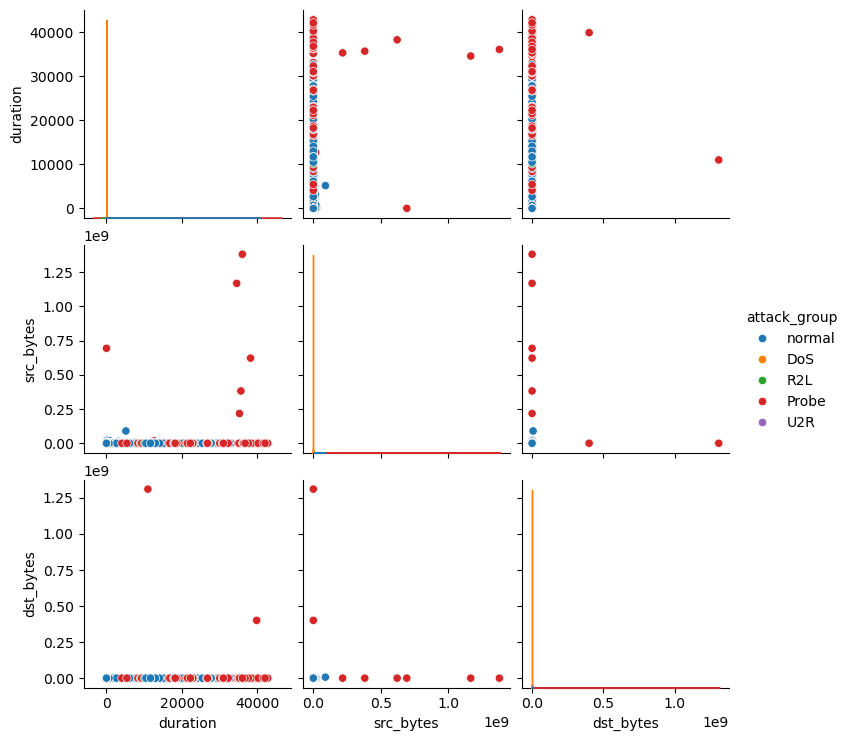

In [47]:
# 6. Pairplot for Feature Interaction
sns.pairplot(kdddset, hue="attack_group", vars=['duration', 'src_bytes', 'dst_bytes'])
plt.show()

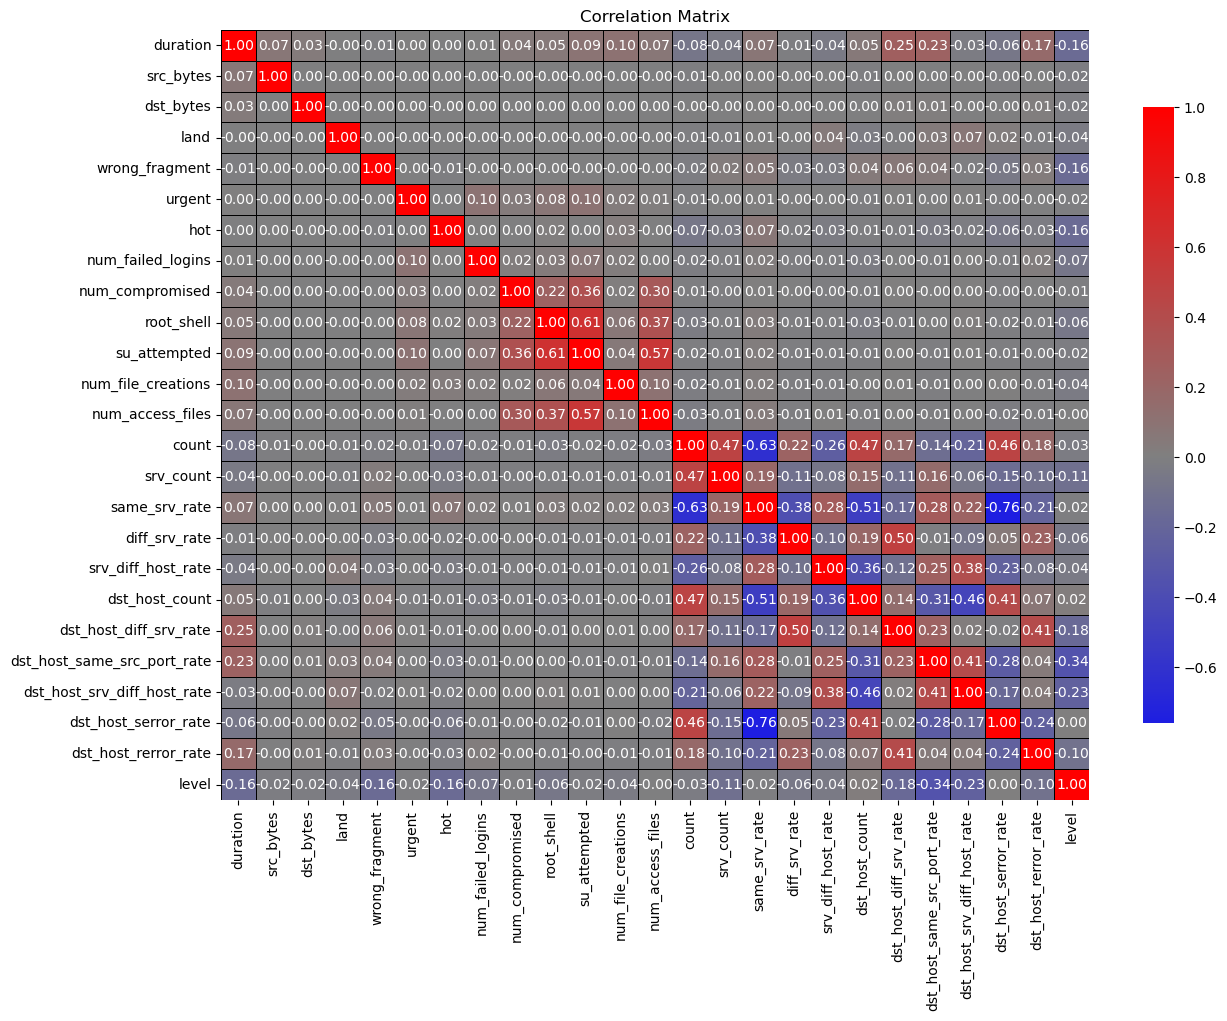

In [48]:
# Define the custom colormap
colors = ["blue", "grey", "red"]
cmap_name = "red_blue_grey"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


numeric_data = kdddset.drop(columns=['protocol_type', 'service', 'flag', 'attack', 'attack_group'])
correlation = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))  # Increase the size of the plot for readability
sns.heatmap(correlation, annot=True, fmt=".2f", cmap=custom_cmap, center=0, 
            linewidths=.5, linecolor='black', cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')
plt.show()

## Principal Component Analysis for further Dimensionality Reduction

In [52]:
from sklearn.preprocessing import StandardScaler

In [126]:
kdddset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  int64  
 2   service                      125973 non-null  int64  
 3   flag                         125973 non-null  int64  
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  num_compromised              125973 non-null  int64  
 12  root_shell                   125973 non-null  int64  
 13 

In [128]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group
0,0,1,20,9,491,0,0,0,0,0,...,0.00,150,0.03,0.17,0.00,0.00,0.05,11,20,4
1,0,2,44,9,146,0,0,0,0,0,...,0.00,255,0.60,0.88,0.00,0.00,0.00,11,15,4
2,0,1,49,5,0,0,0,0,0,0,...,0.00,255,0.05,0.00,0.00,1.00,0.00,9,19,0
3,0,1,24,9,232,8153,0,0,0,0,...,0.00,30,0.00,0.03,0.04,0.03,0.00,11,21,4
4,0,1,24,9,199,420,0,0,0,0,...,0.09,255,0.00,0.00,0.00,0.00,0.00,11,21,4


In [138]:
kdddset['target'] = kdddset['attack_group'].apply(lambda x: 1 if x != 4 else 0)

In [140]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group,target
0,0,1,20,9,491,0,0,0,0,0,...,150,0.03,0.17,0.00,0.00,0.05,11,20,4,0
1,0,2,44,9,146,0,0,0,0,0,...,255,0.60,0.88,0.00,0.00,0.00,11,15,4,0
2,0,1,49,5,0,0,0,0,0,0,...,255,0.05,0.00,0.00,1.00,0.00,9,19,0,1
3,0,1,24,9,232,8153,0,0,0,0,...,30,0.00,0.03,0.04,0.03,0.00,11,21,4,0
4,0,1,24,9,199,420,0,0,0,0,...,255,0.00,0.00,0.00,0.00,0.00,11,21,4,0


In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [144]:
# Label encoding for categorical columns
categorical_columns = ['protocol_type', 'service', 'flag', 'attack', 'attack_group']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    kdddset[col] = le.fit_transform(kdddset[col])
    label_encoders[col] = le

In [146]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group,target
0,0,1,20,9,491,0,0,0,0,0,...,150,0.03,0.17,0.00,0.00,0.05,11,20,4,0
1,0,2,44,9,146,0,0,0,0,0,...,255,0.60,0.88,0.00,0.00,0.00,11,15,4,0
2,0,1,49,5,0,0,0,0,0,0,...,255,0.05,0.00,0.00,1.00,0.00,9,19,0,1
3,0,1,24,9,232,8153,0,0,0,0,...,30,0.00,0.03,0.04,0.03,0.00,11,21,4,0
4,0,1,24,9,199,420,0,0,0,0,...,255,0.00,0.00,0.00,0.00,0.00,11,21,4,0


# Second verifying binary variable 'attack'

In [155]:
# Separate Features and Target
X = kdddset.drop(columns=['attack', 'attack_group', 'target'])
y = kdddset['target']  # or 'attack_group', 'target' based on your analysis

In [157]:
# Standardize the numerical features to have a mean of 0 and a standard deviation of 1.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [159]:
# Now we can apply PCA

pca = PCA(n_components=0.9)  # Retain 90% of variance
X_pca = pca.fit_transform(X_scaled)

# Check the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 20


Principal Component 1 (PC1): This is the direction in the data that captures the maximum variance. It is a linear combination of all the original features.

Principal Component 2 (PC2): This is the next direction, orthogonal to PC1, that captures the second-highest variance. It is also a linear combination of the original features.

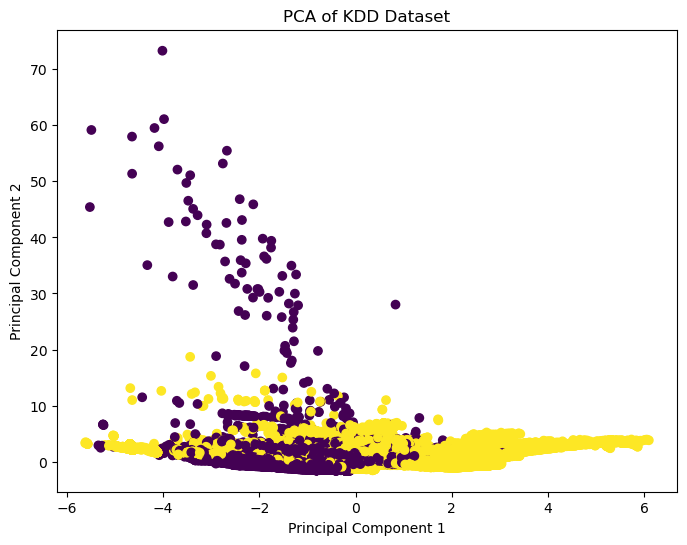

In [162]:
# Visualize PCA Results

# Create a DataFrame for the first two principal components
pca_df = pd.DataFrame(data=X_pca[:, :2], columns=['PC1', 'PC2'])

# Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of KDD Dataset')
plt.show()

In [164]:
# Check variance is captured by each principal component to understand the importance of each component.

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print explained variance
print(f"Explained variance ratio: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance}")

Explained variance ratio: [0.14262682 0.08438289 0.08042205 0.06114875 0.05799972 0.04356385
 0.03943886 0.03915203 0.03793596 0.03605352 0.03571622 0.03548243
 0.03522985 0.03280705 0.03215101 0.02870925 0.02579574 0.0234828
 0.02201897 0.02088284]
Cumulative explained variance: [0.14262682 0.2270097  0.30743175 0.36858051 0.42658022 0.47014408
 0.50958293 0.54873496 0.58667092 0.62272444 0.65844066 0.69392309
 0.72915294 0.76195999 0.79411101 0.82282026 0.848616   0.8720988
 0.89411777 0.91500061]


In [166]:
# PCA component loadings (eigenvectors)
loadings = pd.DataFrame(pca.components_, columns=X.columns)
print(loadings)

    duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0   0.005745       0.061807  0.228897 -0.383299  -0.001221   0.000329   
1   0.252306      -0.120108  0.137513 -0.174950   0.018663   0.018899   
2  -0.069948       0.147319 -0.020986  0.161659  -0.008832  -0.010569   
3   0.249336       0.497807 -0.052355  0.168789   0.027994   0.023934   
4  -0.048428      -0.217326 -0.292290  0.025423  -0.002283   0.001604   
5   0.187242       0.017800  0.236501  0.147086   0.094402   0.048075   
6  -0.010250      -0.073426 -0.174686 -0.150545   0.024541   0.009273   
7   0.482181      -0.130935 -0.090654 -0.059810   0.351931   0.167139   
8   0.251652       0.022467  0.186605  0.062383   0.187147   0.103411   
9   0.010254       0.081382 -0.096930 -0.223653   0.458628   0.257853   
10 -0.004238      -0.011391  0.010266 -0.006108  -0.479721   0.873311   
11 -0.052613      -0.086066  0.049805  0.051307   0.360393   0.146769   
12 -0.026035       0.034783 -0.029977  0.207744   0

In [168]:
# Set a threshold for loadings (e.g., 0.1)
threshold = 0.1

# Identify features with low contributions across most components
low_contributing_features = loadings.columns[(loadings.abs() < threshold).all(axis=0)]
print("Features to consider dropping:", low_contributing_features)

Features to consider dropping: Index([], dtype='object')


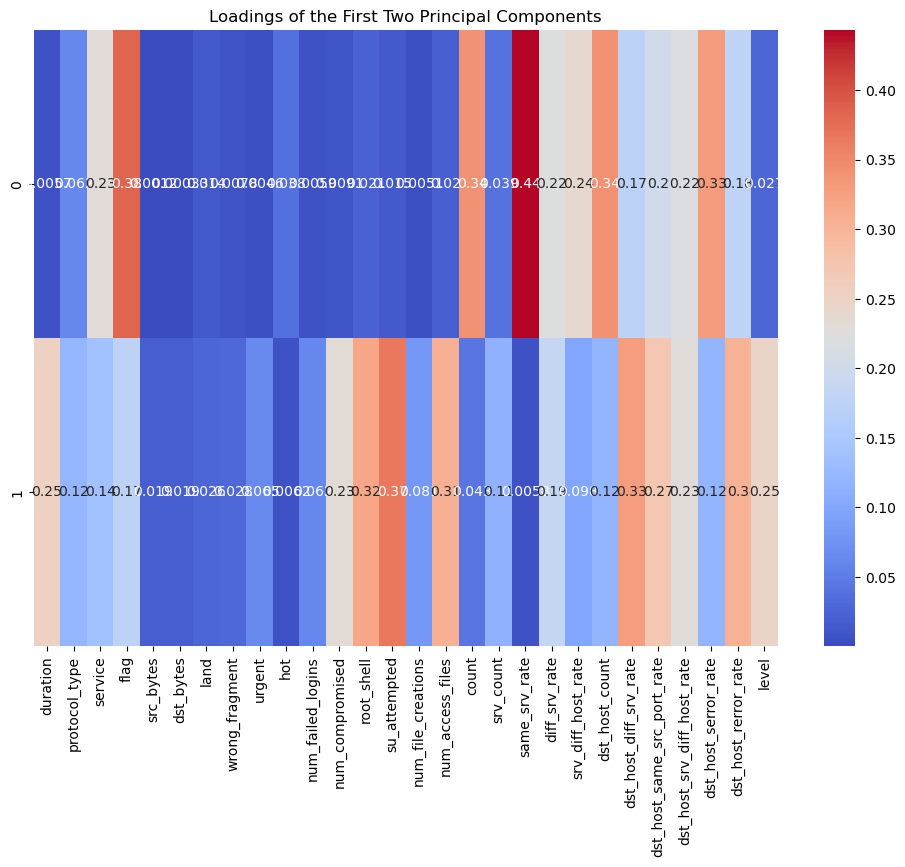

In [170]:
import seaborn as sns

# Visualize the loadings for the first two principal components
plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:2].abs(), cmap='coolwarm', annot=True, xticklabels=X.columns)
plt.title("Loadings of the First Two Principal Components")
plt.show()

In [172]:
#  Find the Most Contributing Features for PC1 and PC2:
# Assuming 'loadings' is the DataFrame that contains the PCA components
loadings = pd.DataFrame(pca.components_, columns=X.columns)

# Get the features that contribute the most to PC1 and PC2
most_important_features_pc1 = loadings.iloc[0].abs().sort_values(ascending=False).head(5)
most_important_features_pc2 = loadings.iloc[1].abs().sort_values(ascending=False).head(5)

print("Top 5 features contributing to PC1:\n", most_important_features_pc1)
print("Top 5 features contributing to PC2:\n", most_important_features_pc2)

Top 5 features contributing to PC1:
 same_srv_rate           0.443209
flag                    0.383299
dst_host_count          0.342397
count                   0.340436
dst_host_serror_rate    0.329699
Name: 0, dtype: float64
Top 5 features contributing to PC2:
 su_attempted              0.366007
dst_host_diff_srv_rate    0.327739
root_shell                0.317400
num_access_files          0.305395
dst_host_rerror_rate      0.304391
Name: 1, dtype: float64


In [174]:
# Create a DataFrame with the principal components
num_components = X_pca.shape[1]
pca_columns = [f'PC{i+1}' for i in range(num_components)]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

In [176]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.361634,-0.462804,0.294046,0.330646,-0.461852,-0.252048,0.177737,0.159721,-0.063695,0.007863,0.005116,-0.026243,0.086769,-0.128648,0.047310,-0.047935,0.472505,0.356722,-0.239010,0.253276
1,0.599591,1.601378,-1.140861,2.383819,-0.191443,1.438290,-1.166616,-0.788424,0.126889,-1.071469,-0.066424,0.277166,1.304671,-0.403072,-0.117109,-0.155925,1.125085,-0.712688,0.832878,-1.632679
2,2.207460,-0.375036,0.369386,-1.008896,-0.056274,1.015842,-0.329994,0.009180,0.174840,-0.037073,0.027987,0.157695,-0.025194,-0.281552,0.106428,-0.015329,-0.005994,0.023832,0.182078,-0.280433
3,-1.721008,-0.552262,0.345291,-0.188505,-0.809062,-0.439112,0.197629,0.081005,0.006968,0.041532,-0.003368,-0.035591,0.015700,0.038622,-0.031915,-0.033782,0.426915,0.801628,-0.192168,0.102644
4,-0.892542,-0.938393,0.699114,0.403705,-0.283515,-0.400638,0.113556,0.175713,0.083418,-0.048974,0.007023,-0.085694,0.087183,-0.011106,-0.003614,0.019560,-0.217216,-0.028185,-0.188420,0.412419


In [178]:
# Add the target variable back to the DataFrame
pca_df['target'] = y.values  # Or df['attack'] 

In [180]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target
0,-1.361634,-0.462804,0.294046,0.330646,-0.461852,-0.252048,0.177737,0.159721,-0.063695,0.007863,...,-0.026243,0.086769,-0.128648,0.047310,-0.047935,0.472505,0.356722,-0.239010,0.253276,0
1,0.599591,1.601378,-1.140861,2.383819,-0.191443,1.438290,-1.166616,-0.788424,0.126889,-1.071469,...,0.277166,1.304671,-0.403072,-0.117109,-0.155925,1.125085,-0.712688,0.832878,-1.632679,0
2,2.207460,-0.375036,0.369386,-1.008896,-0.056274,1.015842,-0.329994,0.009180,0.174840,-0.037073,...,0.157695,-0.025194,-0.281552,0.106428,-0.015329,-0.005994,0.023832,0.182078,-0.280433,1
3,-1.721008,-0.552262,0.345291,-0.188505,-0.809062,-0.439112,0.197629,0.081005,0.006968,0.041532,...,-0.035591,0.015700,0.038622,-0.031915,-0.033782,0.426915,0.801628,-0.192168,0.102644,0
4,-0.892542,-0.938393,0.699114,0.403705,-0.283515,-0.400638,0.113556,0.175713,0.083418,-0.048974,...,-0.085694,0.087183,-0.011106,-0.003614,0.019560,-0.217216,-0.028185,-0.188420,0.412419,0


# K Nearest Neighbors (KNN) classification model

In [183]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [187]:
# Step 1: drop target
X = pca_df.drop(columns=['target'])  # PCA features
y = pca_df['target']  # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Step 4: Train the KNN model
knn.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = knn.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print detailed evaluation metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9978170271879341
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13422
           1       1.00      1.00      1.00     11773

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

[[13395    27]
 [   28 11745]]


# Convolutional Neural Network (CNN)  

In [190]:
# Reshape data into a 3D format for CNN: (samples, features, 1 channel)
X = pca_df.drop(columns=['target']).values
y = pd.get_dummies(pca_df['target']).values  # One-hot encoding for multi-class classification

# Reshape X for CNN
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [192]:
# Define CNN model

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Add a 1D Convolutional layer
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a pooling layer
model.add(layers.MaxPooling1D(pool_size=2))

# Add another Convolutional layer (optional)
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))

# Add a flatten layer to flatten the output
model.add(layers.Flatten())

# Add a dense fully connected layer
model.add(layers.Dense(128, activation='relu'))

# Add the output layer (number of classes = number of unique attack groups)
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [194]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [196]:
# Train the CNN model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9774 - loss: 0.0791 - val_accuracy: 0.9924 - val_loss: 0.0228
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9923 - loss: 0.0233 - val_accuracy: 0.9925 - val_loss: 0.0204
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9942 - loss: 0.0165 - val_accuracy: 0.9945 - val_loss: 0.0159
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.9945 - val_loss: 0.0149
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9954 - loss: 0.0118 - val_accuracy: 0.9941 - val_loss: 0.0148
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9962 - loss: 0.0114 - val_accuracy: 0.9949 - val_loss: 0.0129
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9959 - loss: 0.0112 - val_accuracy: 0.9960 - val_loss: 0.0124
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9965 - loss: 0.0101 - 

In [198]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9977 - loss: 0.0093
Test accuracy: 0.9977376461029053


#  Recurrent Neural Network (RNN)

In [201]:
from sklearn.preprocessing import OneHotEncoder

# Prepare features (X) and target (y)
X = pca_df.drop(columns=['target']).values
y = pca_df['target'].values

# Reshape X for RNN (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Use 1 timestep since each sample is independent

# One-hot encode target variable if it's multi-class
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

In [203]:
# Build the RNN model
model = models.Sequential()
model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [205]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [207]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 529us/step - accuracy: 0.9748 - loss: 0.0854 - val_accuracy: 0.9914 - val_loss: 0.0265
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 499us/step - accuracy: 0.9924 - loss: 0.0236 - val_accuracy: 0.9929 - val_loss: 0.0178
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 501us/step - accuracy: 0.9936 - loss: 0.0174 - val_accuracy: 0.9943 - val_loss: 0.0183
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 499us/step - accuracy: 0.9946 - loss: 0.0149 - val_accuracy: 0.9946 - val_loss: 0.0129
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 500us/step - accuracy: 0.9950 - loss: 0.0136 - val_accuracy: 0.9949 - val_loss: 0.0131
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step - accuracy: 0.9957 - loss: 0.0113 - val_accuracy: 0.9954 - val_loss: 0.0133
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 499us/step - accuracy: 0.9961 - loss: 0.0104 - val_accuracy: 0.9957 - val_loss: 0.0119
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 499us/step - accuracy: 0.9961 -

In [209]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.9963 - loss: 0.0147
Test accuracy: 0.9961897134780884


In [211]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))

788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13422
           1       1.00      1.00      1.00     11773

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

[[13384    38]
 [   58 11715]]
